# marsupial: finding and identifying animals in camera trap images

## Example uses

There are many ways to use our models to make predictions and detections. 
Our models are by default available as `PyTorch` weights, which makes them easy to integrate into any workflows using `PyTorch` or the broader `Torch` ecosystem.
The model weights can also be easil converted into other popular deep learning formats, including light weight options like onnx and open vino. 

This guide is aimed at users who have some knowleged of Python; if you aren't familiar with using Python for deep learning it would be a good idea to have a look at the excellent tutorials available from `PyTorch`.

### Making predictions with marsupial using PyTorch

PyTorch is one of the leading industry standard libraries for machine learning and deep learning. 

First, we need to import a few libraries.

In [20]:
import os
import re
import json
import pathlib
import subprocess
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path 
from PIL import Image
from datetime import datetime

%matplotlib inline  
import torchvision
import matplotlib.pyplot as plt

Then, we can load in one of our models. In this case, we will use a  72 species model.

In [6]:
# For this example, we will load in the 72 species model
model = torch.hub.load('ultralytics/yolov5', 'custom', 'weights/marsupial_72s.pt')

Using cache found in /Users/henrylydecker/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-5-11 torch 1.12.1 CPU

Fusing layers... 
Model summary: 213 layers, 7204309 parameters, 0 gradients
Adding AutoShape... 


Once the model is loaded, we can pass objects to it and save them in memory as predictions. 

In [52]:
# Specify the path to an image file to predict on
image = "data/koala2.jpg"

# Pass the image path to our model
results = model(image)

results.pandas()
results.xyxy[0]  # im predictions (tensor)
results.pandas().xyxy[0]  # im predictions (pandas)

,xmin,ymin,xmax,ymax,confidence,class,name
0,455.115234,490.108337,961.205994,828.426147,0.903416,64,Koala


Our model has found one koala in the image; let's visualise the model's predictions to see if they look reasoable:

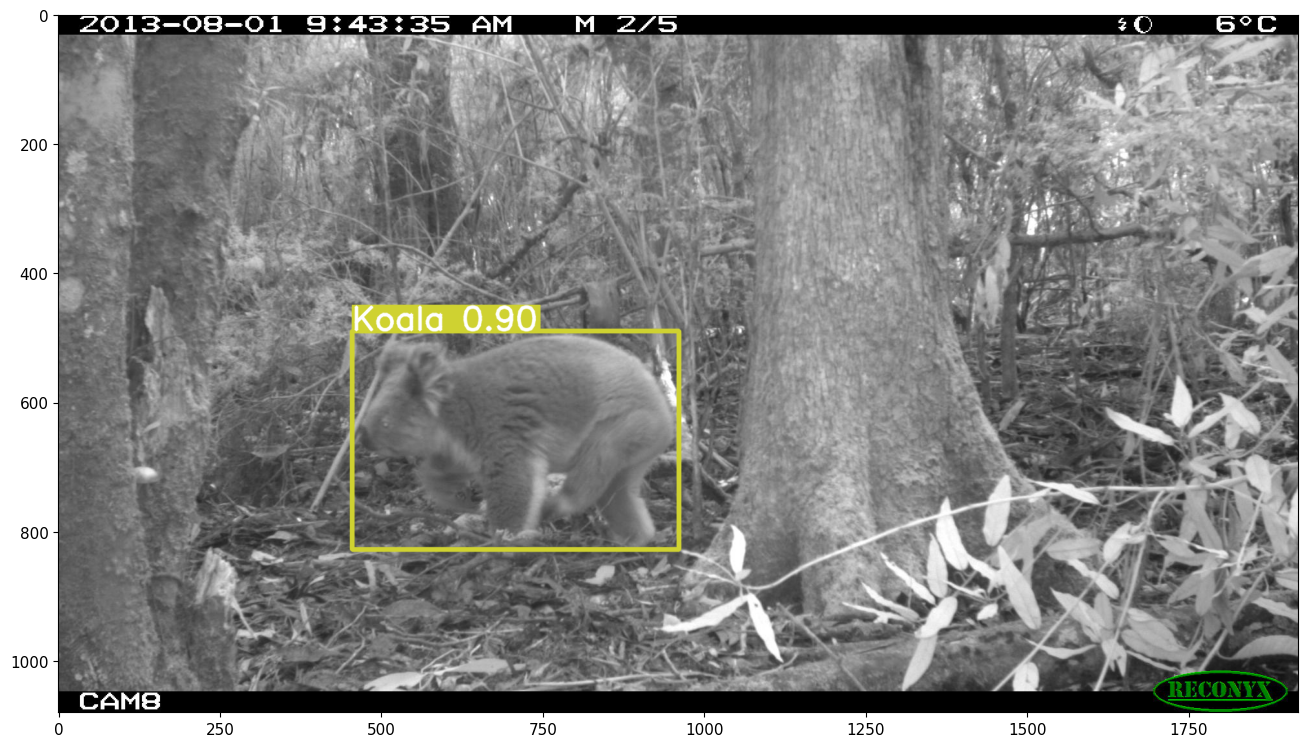

In [53]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(results.render()[0])
plt.show()

That looks pretty good! The model has drawn a bounding box perfectly covering the one animal in this image, which looks to pretty clearly be a Koala walking along the ground.

#### Building functions with marsupial's models

Now that we can make a prediction on one single image, we can then build some functions to allow us to make predictions on multiple images.
We can also make functions to help us visualise and summarise results.

In [37]:
"""
Prediction functions
"""

def predict_single_image(image_file):
    
    im = image_file
    results = model(im)
    results.pandas().xyxy[0] 
    
    return(results.pandas().xyxy[0])

def predict_images(image_dir, summary = False):
    
    predictions = [] 
    
    image_dir = pathlib.Path(image_dir)
    
    for image in tqdm(image_dir.glob("*.jpg")):
        
        prediction = predict_single_image(image)
        prediction['fullpath'] = image
        prediction['filename'] = os.path.basename(image) 
        predictions.append(prediction)
                       
    prediction_df = pd.concat(predictions)
    
    if summary == True:
        print("Detection Summary")
        print(prediction_df.groupby(['name'])['name'].count().sort_values(ascending=False))
        
    return(prediction_df)

"""
Image EXIF utilities

This set of functions is to extract information from image EXIF data. 

These functions are very useful when working with EXIF anotated images, like the NSWNP Wildcount dataset.
"""

def species_annotation_from_exif(image_file):
    # Get original species ID
    cmd="exiftool -Keywords " + '''"''' + str(image_file) + '''"'''
    image_keywords = subprocess.getoutput([cmd])
    species = re.findall(r'(?<=a\)\s).+?(?=\s\([a-zA-z])', image_keywords)
    return(species)

def date_time_original_from_exif(image_file):
    # Get DateTimeOriginal
    cmd="exiftool -DateTimeOriginal " + '''"''' + str(image_file) + '''"'''
    date_time_original = subprocess.getoutput([cmd])
    date_time_original = re.findall(r'(?<=:\s)(.*)', date_time_original)
    return(date_time_original)

def camera_name_from_exif(image_file):
    # Get Camera Name
    cmd="exiftool -UserLabel " + '''"''' + str(image_file) + '''"'''
    camera_name = subprocess.getoutput([cmd])
    camera_name = re.findall(r'(?<=:\s)(.*)', camera_name)
    return(camera_name)

def date_from_exif(image_file):
    # Get date
    cmd = "exiftool -DateTimeOriginal " + '''"''' + str(image_file) + '''"'''
    date = subprocess.getoutput([cmd])
    date = re.findall(r'(?<=:\s)([^\s]+)', date)
    return(date)

def time_from_exif(image_file):
    # Get time
    cmd = "exiftool -DateTimeOriginal " + '''"''' + str(image_file) + '''"'''
    time = subprocess.getoutput([cmd])
    time = time[time.rindex(' ')+1:]
    return(time)

We can then pass a path to a directory containing images, and this function will recursively look for any images, load them in, and make predictions on all of the images using our model.

Predictions will then be saved into a `pandas` dataframe, which can be analysed in Python or easily exported into a spreadsheet for analysis using other tools like R or Excel,

In [36]:
predictions = predict_images("data") 
 
predictions

12it [00:02,  4.40it/s]


,xmin,ymin,xmax,ymax,confidence,class,name,fullpath,filename
0,146.202438,193.257645,311.983063,288.033905,0.933581,20,Mountain Brushtail Possum,data/BrushtailPossum.jpg,BrushtailPossum.jpg
0,455.115234,490.108337,961.205994,828.426147,0.903416,64,Koala,data/koala2.jpg,koala2.jpg
0,989.692383,546.069824,1325.369019,1051.991821,0.881009,23,Cat,data/cat1.jpg,cat1.jpg
0,38.509991,161.055267,290.907806,300.832245,0.936678,56,Wedge-tailed Eagle,data/Eagle.jpg,Eagle.jpg
0,728.963318,884.916992,1413.578491,1293.600586,0.682730,23,Cat,data/tawny_frogmouth.jpg,tawny_frogmouth.jpg
0,602.422974,716.410583,986.186890,1018.210938,0.933168,29,Australian Magpie,data/magpie.jpg,magpie.jpg
0,0.777562,292.635437,422.179230,626.650146,0.933250,23,Cat,data/cat.jpg,cat.jpg
0,619.546326,715.897156,1578.911865,1513.666138,0.934307,6,Red Fox,data/red_fox.jpg,red_fox.jpg
0,140.057373,23.666748,998.016418,1030.468994,0.901568,2,Eastern Grey Kangaroo,data/easter_grey_kangaroo.jpg,easter_grey_kangaroo.jpg
0,1087.885010,814.615295,1848.107056,1122.206299,0.901736,1,Common Brushtail Possum,data/brushtail_possum.jpg,brushtail_possum.jpg


We can also print out a summary of the number of observations for each species detected:

In [54]:
# We can enable printing a summary by setting summary to True
predictions = predict_images("data", summary = True) 

# OR we can always just do it ourselves with the output of predict_images:
# print(predictions.groupby(['name'])['name'].count().sort_values(ascending=False))

12it [00:04,  2.73it/s]

Detection Summary


name
Cat                          3
Australian Magpie            1
Common Brushtail Possum      1
Eastern Grey Kangaroo        1
Koala                        1
Mountain Brushtail Possum    1
Red Fox                      1
Wedge-tailed Eagle           1
Name: name, dtype: int64
